# DQN (train)
https://simoninithomas.github.io/Deep_reinforcement_learning_Course/  
https://medium.freecodecamp.org/an-introduction-to-deep-q-learning-lets-play-doom-54d02d8017d8  
https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682  
https://github.com/yandexdataschool/Practical_RL/blob/master/week4_approx_rl/homework_pytorch.ipynb  
http://maciejjaskowski.github.io/2016/03/09/space-invaders.html  
https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf

## 1. Setup

In [1]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import gym
import sys
import tensorflow as tf

from collections import deque
from dqn import DQN
from params import *
from preprocessing import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

print(f'sys.version: {sys.version}')
print(f'skimage.version: {skimage.__version__}')
print(f'tf.version: {tf.__version__}')

sys.version: 3.6.7 |Anaconda, Inc.| (default, Oct 23 2018, 19:16:44) 
[GCC 7.3.0]
skimage.version: 0.14.1
tf.version: 1.11.0


## 2. Look at the Breakout-v0 env

In [2]:
env = gym.make('Breakout-v0')
env.reset()
env.render()
print(f'action_space.size: {env.action_space.n}')

action_space.size: 4


In [3]:
print(f'Num_Actions: {env.action_space.n}')
action_meanings = env.unwrapped.get_action_meanings()
for i in range(env.action_space.n):
    print(f'{i}: {action_meanings[i]}')

Num_Actions: 4
0: NOOP
1: FIRE
2: RIGHT
3: LEFT


__Look how the rgb frame is preprocessed__

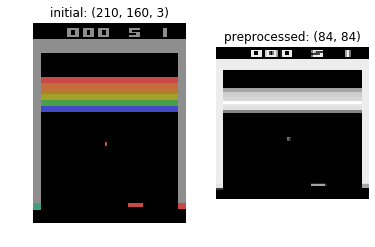

In [4]:
env.reset()
rgb_frame, _, _, _ = env.step(1)
preprocessed_frame = preprocess_frame(rgb_frame)

plt.figure()

plt.subplot(1, 2, 1)
plt.title(f'initial: {rgb_frame.shape}')
plt.axis('off')
plt.imshow(rgb_frame)

plt.subplot(1, 2, 2)
plt.title(f'preprocessed: {preprocessed_frame.shape}')
plt.axis('off')
plt.imshow(preprocessed_frame, cmap='gray')

plt.show()

## 3. DQN

### CNN architecture
1. Conv2d(filters=32, kernel_size=8, strides=4, padding='valid', activation=ReLU)
2. Conv2d(filters=64, kernel_size=4, strides=2, padding='valid', activation=ReLU)  
2. Conv2d(filters=64, kernel_size=3, strides=1, padding='valid', activation=ReLU) -> Flatten()  
3. FC(512, activation=ReLU)
4. FC(NUM_ACTIONS, activation=Linear)

### Instantiate DQNs: DQN and TargetDQN

In [5]:
tf.reset_default_graph()

dqn = DQN(state_shape=STATE_SHAPE, action_size=ACTION_SIZE, dqn_name='DQN')
dqn_target = DQN(state_shape=STATE_SHAPE, action_size=ACTION_SIZE, dqn_name='DQNTarget')

## 4. Training

### Memory class (for Experience Replay)

In [6]:
class Memory:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        indices = np.random.choice(np.arange(buffer_size),
                                   size=batch_size,
                                   replace=False)
        experiences_batch = [self.buffer[idx] for idx in indices]
        return experiences_batch

#### Pre-populate memory by taking random actions and storing each experience (state, action, reward, next_state, done)

In [7]:
def get_pre_populated_memory(env):
    memory = Memory(max_size=MEMORY_SIZE)
    stacked_frames = []
    state = None

    for step in range(PRETRAIN_LENGTH):
        if step == 0:
            state = env.reset()
            state, stacked_frames = stack_frames(stacked_frames, state,
                                                 is_new_episode=True)

        # random action
        action_idx = np.random.randint(ACTION_SIZE)
        action = POSSIBLE_ACTIONS[action_idx]
        
        # next state
        next_state, reward, done, _ = env.step(action)
        next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                  is_new_episode=False)

        if done:
            # the end of episode (next_state = 0)
            next_state = np.zeros(STATE_SHAPE)
            next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                      is_new_episode=False)

            # add experience to memory
            memory.add((state, action_idx, reward, next_state, done))

            # start a new episode
            state = env.reset()
            state, stacked_frames = stack_frames(stacked_frames, state,
                                                 is_new_episode=True)
        else:
            # add experience to memory
            memory.add((state, action_idx, reward, next_state, done))
            state = next_state
    
    return memory

### Helper function to copy DQN parameters to DQNTarget

In [8]:
def update_dqn_target():
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DQN')
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'DQNTarget')
    
    op_holder = []
    for from_var, to_var in zip(from_vars, to_vars):
        op_holder.append(to_var.assign(from_var))
        
    return op_holder

### DQN (training algorithm)

In [9]:
def eps_greedy(sess, state, eps_decay_step):
    # eps: exploration probability
    eps = EPS_END + (EPS_START - EPS_END) * np.exp(-EPS_DECAY_RATE * eps_decay_step)
    
    if np.random.rand() < eps:
        # exploration with eps probability
        action_idx = np.random.randint(ACTION_SIZE)
    else:
        # exploitation with (1 - eps) probability
        Q = sess.run(dqn.output,
                     feed_dict={
                         dqn.input_ph: state.reshape(1, *STATE_SHAPE)
                     })
        
        action_idx = np.argmax(Q)

    return action_idx, eps

In [10]:
def dqn_training(dqn, dqn_target,
                 num_episodes=NUM_EPISODES, 
                 max_steps_per_episode=MAX_STEPS_PER_EPISODE, 
                 batch_size=BATCH_SIZE,
                 learning_rate=LEARNING_RATE):
    
    # memory for experience replay
    memory = get_pre_populated_memory(env)
    
    # update dqn target op
    update_dqn_target_op = update_dqn_target()    
    
    # to save some ckpts
    saver = tf.train.Saver(max_to_keep=30)
    
    with tf.Session() as sess:
        # init tf variables
        sess.run(tf.global_variables_initializer())
        
        # init dqn_target with the same params as dqn
        sess.run(update_dqn_target_op)
        
        step = 0
        best_rewards = [0 for _ in range(2)]
        best_episodes = [[] for _ in range(2)]
        iters_per_episode = []
        reward_per_episode = []
        loss_per_iter = []
        
        for episode in range(1, num_episodes + 1):
            episode_step = 0
            done = False
            stacked_frames = []
            episode_rewards = []
            episode_states = []
            
            # new episode
            state = env.reset()
            episode_states.append(state)
            state, stacked_frames = stack_frames(stacked_frames, state,
                                                 is_new_episode=True)
            
            
            while (not done) and (episode_step < max_steps_per_episode):
                episode_step += 1
                step += 1
                
                action_idx, eps = eps_greedy(sess, state, step)
                action = POSSIBLE_ACTIONS[action_idx]
                next_state, reward, done, _ = env.step(action)
                episode_rewards.append(reward)
                episode_states.append(next_state)
                
                if done:
                    # the end of episode (next_state = 0)
                    next_state = np.zeros(STATE_SHAPE)
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                              is_new_episode=False)
                    # add experience to memory
                    memory.add((state, action_idx, reward, next_state, done))
                    
                    total_reward = np.sum(episode_rewards)
                    reward_per_episode.append(total_reward)
                    iters_per_episode.append(episode_step)
                    
                    print(f'Episode: {episode}, '
                          f'Total reward: {total_reward}, '
                          f'Epsilon: {eps}')
                else:
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state,
                                                              is_new_episode=False)
                    # add experience to memory
                    memory.add((state, action_idx, reward, next_state, done))
                    
                    state = next_state
                    
                ### learning part ###
                # sample a random batch of experiences from memory
                batch = memory.sample(batch_size)
                batch_states = np.array([experience[0] for experience in batch], ndmin=3)
                batch_action_indices = np.array([experience[1] for experience in batch])
                batch_rewards = np.array([experience[2] for experience in batch])
                batch_next_states = np.array([experience[3] for experience in batch], ndmin=3)
                batch_dones = np.array([experience[4] for experience in batch])

                # if the episode ends at next_state:
                #     Q_target(state) = reward
                # else:
                #     Q_target(state) = reward + gamma * max(a){Q_next_state}
                Q_batch_next_state = sess.run(dqn_target.output,
                                              feed_dict={
                                                  dqn_target.input_ph: batch_next_states
                                              })
                
                # terminal states => Q value = 0
                Q_batch_next_state[batch_dones, :] = 0
                
                Q_target = batch_rewards + GAMMA * np.max(Q_batch_next_state, axis=1)
                
                loss, _ = sess.run([dqn.loss, dqn.optimization_step],
                                   feed_dict={
                                       dqn.input_ph: batch_states,
                                       dqn.action_indices_ph: batch_action_indices,
                                       dqn.Q_target_ph: Q_target,
                                       dqn.learning_rate_ph: learning_rate
                                   })
                
                if step % Q_TARGET_UPDATE_FREQ == 0:
                    print('Update parameters of DQNTarget')
                    sess.run(update_dqn_target_op)
                
                loss_per_iter.append(loss)
            
            # keep 2 train episodes with high reward
            min_pos = np.argmin(best_rewards)
            max_pos = np.argmax(best_rewards)
            min_reward = best_rewards[min_pos]
            max_reward = best_rewards[max_pos]
            cur_reward = reward_per_episode[-1]
            
            if cur_reward > max_reward:
                best_episodes[min_pos] = best_episodes[max_pos]
                best_rewards[min_pos] = best_rewards[max_pos]
                best_episodes[max_pos] = [episode, cur_reward, episode_states]
                best_rewards[max_pos] = cur_reward
            elif cur_reward > min_reward:
                best_episodes[min_pos] = [episode, cur_reward, episode_states]
                best_rewards[min_pos] = cur_reward
            
            if (episode == 1) or (episode % SAVE_EVERY == 0):
                saver.save(sess, f'{SAVE_PATH}/model_episode_{episode}.ckpt')
                print('Model saved')
                
    return iters_per_episode, reward_per_episode, loss_per_iter, best_episodes

In [11]:
%%time
!rm -rf $SAVE_PATH
train_stats = dqn_training(dqn, dqn_target, num_episodes=NUM_EPISODES)

Episode: 1, Total reward: 3.0, Epsilon: 0.965567058815906
Model saved
Episode: 2, Total reward: 1.0, Epsilon: 0.9430930641895854
Episode: 3, Total reward: 1.0, Epsilon: 0.9207832495757172
Episode: 4, Total reward: 1.0, Epsilon: 0.8976743414505883
Episode: 5, Total reward: 1.0, Epsilon: 0.8779246855780929
Episode: 6, Total reward: 1.0, Epsilon: 0.8604834420256393
Episode: 7, Total reward: 2.0, Epsilon: 0.8348527974890472
Episode: 8, Total reward: 1.0, Epsilon: 0.8179538520807833
Episode: 9, Total reward: 0.0, Epsilon: 0.801638575133082
Episode: 10, Total reward: 1.0, Epsilon: 0.7816298322507778
Episode: 11, Total reward: 0.0, Epsilon: 0.7690783068305727
Episode: 12, Total reward: 1.0, Epsilon: 0.7528580250855292
Update parameters of DQNTarget
Episode: 13, Total reward: 0.0, Epsilon: 0.7392414928968223
Episode: 14, Total reward: 0.0, Epsilon: 0.7265191278392991
Episode: 15, Total reward: 0.0, Epsilon: 0.7140891228680755
Episode: 16, Total reward: 3.0, Epsilon: 0.6923924574411601
Episode:

Update parameters of DQNTarget
Episode: 130, Total reward: 4.0, Epsilon: 0.036398440676628785
Episode: 131, Total reward: 1.0, Epsilon: 0.035625935474870335
Episode: 132, Total reward: 8.0, Epsilon: 0.034206106671531726
Episode: 133, Total reward: 0.0, Epsilon: 0.03376241054181941
Episode: 134, Total reward: 1.0, Epsilon: 0.033046293251541126
Episode: 135, Total reward: 3.0, Epsilon: 0.0322402774178469
Episode: 136, Total reward: 1.0, Epsilon: 0.031516174252714343
Episode: 137, Total reward: 2.0, Epsilon: 0.03087818727947568
Episode: 138, Total reward: 3.0, Epsilon: 0.030063554156351542
Update parameters of DQNTarget
Episode: 139, Total reward: 2.0, Epsilon: 0.02944140253182448
Episode: 140, Total reward: 1.0, Epsilon: 0.028776478504569665
Episode: 141, Total reward: 3.0, Epsilon: 0.02810892558790739
Episode: 142, Total reward: 5.0, Epsilon: 0.027198203713923036
Episode: 143, Total reward: 3.0, Epsilon: 0.02650898772362993
Episode: 144, Total reward: 2.0, Epsilon: 0.026078853205290804


Episode: 254, Total reward: 3.0, Epsilon: 0.0104683239335145
Episode: 255, Total reward: 0.0, Epsilon: 0.010460199560283486
Episode: 256, Total reward: 0.0, Epsilon: 0.010451222344846703
Episode: 257, Total reward: 1.0, Epsilon: 0.010437186650655234
Episode: 258, Total reward: 3.0, Epsilon: 0.010418869837838634
Episode: 259, Total reward: 0.0, Epsilon: 0.010407548613342137
Update parameters of DQNTarget
Episode: 260, Total reward: 2.0, Epsilon: 0.010393491797284176
Episode: 261, Total reward: 0.0, Epsilon: 0.010384929508265995
Episode: 262, Total reward: 2.0, Epsilon: 0.010370724879236218
Episode: 263, Total reward: 4.0, Epsilon: 0.010352468135390407
Episode: 264, Total reward: 2.0, Epsilon: 0.010341606750149768
Episode: 265, Total reward: 1.0, Epsilon: 0.010334173467561589
Episode: 266, Total reward: 0.0, Epsilon: 0.010327228996892245
Episode: 267, Total reward: 1.0, Epsilon: 0.01031572141356703
Episode: 268, Total reward: 3.0, Epsilon: 0.010303463160859972
Update parameters of DQNTar

Episode: 378, Total reward: 1.0, Epsilon: 0.010009748956192612
Episode: 379, Total reward: 1.0, Epsilon: 0.010009453265355744
Episode: 380, Total reward: 0.0, Epsilon: 0.010009214333143694
Episode: 381, Total reward: 0.0, Epsilon: 0.010009012930082254
Episode: 382, Total reward: 1.0, Epsilon: 0.010008732574439745
Episode: 383, Total reward: 2.0, Epsilon: 0.010008349154047977
Update parameters of DQNTarget
Episode: 384, Total reward: 2.0, Epsilon: 0.010008099968899562
Episode: 385, Total reward: 2.0, Epsilon: 0.010007821373840936
Episode: 386, Total reward: 1.0, Epsilon: 0.010007590976369832
Episode: 387, Total reward: 4.0, Epsilon: 0.010007205612398134
Episode: 388, Total reward: 2.0, Epsilon: 0.0100069647396175
Episode: 389, Total reward: 4.0, Epsilon: 0.010006672270602155
Episode: 390, Total reward: 2.0, Epsilon: 0.010006399758287734
Episode: 391, Total reward: 0.0, Epsilon: 0.01000626488493658
Update parameters of DQNTarget
Episode: 392, Total reward: 2.0, Epsilon: 0.010006074260309

#### Training stats

In [12]:
iters_per_episode, reward_per_episode, loss_per_iter, best_episodes = train_stats

#### Save episodes with high reward during training phase (max 2)

In [13]:
#!rm -rf ./train_stats
#!mkdir ./train_stats

In [14]:
%%time
for episode, reward, frames in best_episodes:
    np.save(f'./train_stats/train_episode_{episode}_reward_{int(reward)}.npy', frames)

CPU times: user 44 ms, sys: 92 ms, total: 136 ms
Wall time: 514 ms


#### Some plots

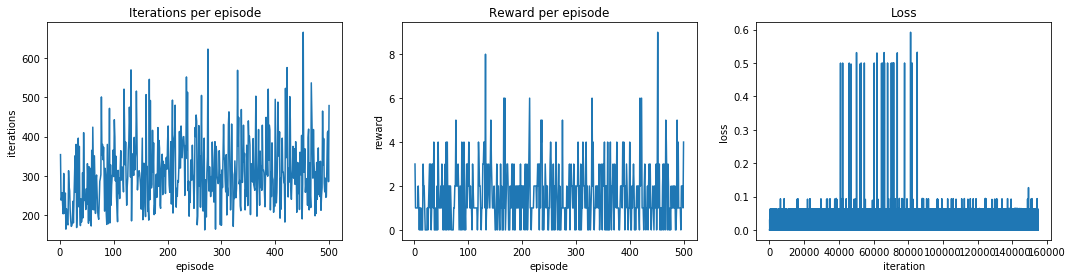

In [15]:
episode_range = np.arange(len(iters_per_episode)) + 1
iter_range = np.arange(len(loss_per_iter)) + 1

plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.title('Iterations per episode')
plt.plot(episode_range, iters_per_episode)
plt.ylabel('iterations')
plt.xlabel('episode')

plt.subplot(1, 3, 2)
plt.title('Reward per episode')
plt.plot(episode_range, reward_per_episode)
plt.ylabel('reward')
plt.xlabel('episode')

plt.subplot(1, 3, 3)
plt.title('Loss')
plt.plot(iter_range, loss_per_iter)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.show()